### Jeju Guest Consumption
제주 관광객의 소비 지역 & 소비 업종 파악 EDA

- 활용 데이터 
    - 데이콘 '공간정보 탐색적 데이터 분석 경진대회' 제주 결제 데이터 (https://dacon.io/competitions/official/235682/data/)
    - 제주도 행정구역 정보
    - 카카오 오픈 API

In [22]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import folium
from matplotlib import font_manager, rc
from pyproj import Proj, transform
from IPython.display import Image
import os

# 한글 폰트 설정
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~~')

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [21]:
admin_district_url = '../datas/jeju_district.csv'
district = pd.read_csv(admin_district_url, sep=',', encoding='utf-8', names=['sigungu', 'dong'])
admin_district_pivot = district.pivot_table(index='sigungu', values='dong', aggfunc=lambda x: ' '.join(x))
admin_district_pivot

dong
sigungu                                                   
서귀포시     대정읍 남원읍 성산읍 안덕면 표선면 송산동 정방동 중앙동 천지동 효돈동 영천동 동홍...
제주시      한림읍 애월읍 구좌읍 조천읍 한경면 추자면 우도면 일도1동 일도2동 이도1동 이도2...

In [6]:
consumption_url = '../datas/detailed_consume_type_data.csv'
consumption = pd.read_csv(consumption_url, sep=',', encoding='utf-8')

# 관광객 8개 주 소비 업종 
tour_types= ['1급호텔', '2급호텔', '렌트카', '면세점', '여객선', '콘도', '특급호텔', '항공사']
data_tour = consumption.loc[consumption.Type.isin(tour_types)]
data_tour.tail(3)

YM     Sido Sigungu FranClass Type Time  TotalSpent  DisSpent  \
272845  202005  제주특별자치도    서귀포시        일반   콘도   x시       56400         0   
272883  202005  제주특별자치도    서귀포시        일반   콘도   x시      201000         0   
273136  202005  제주특별자치도    서귀포시        일반   콘도   x시      122800         0   

        NumofSpent  NumofDisSpent      POINT_X      POINT_Y LargeCategory  \
272845           1              0  927857.0808  1485406.856           숙박업   
272883           2              0  934082.9022  1479488.988           숙박업   
273136           3              0  946762.1456  1493244.350           숙박업   

       MediumCategory  
272845       휴양콘도 운영업  
272883       휴양콘도 운영업  
273136       휴양콘도 운영업

#### 제주시, 서귀포시 관광업종 매출액 비교
- 공항이 있는 제주시의 관광업종 매출이 서귀포시보다 높다.

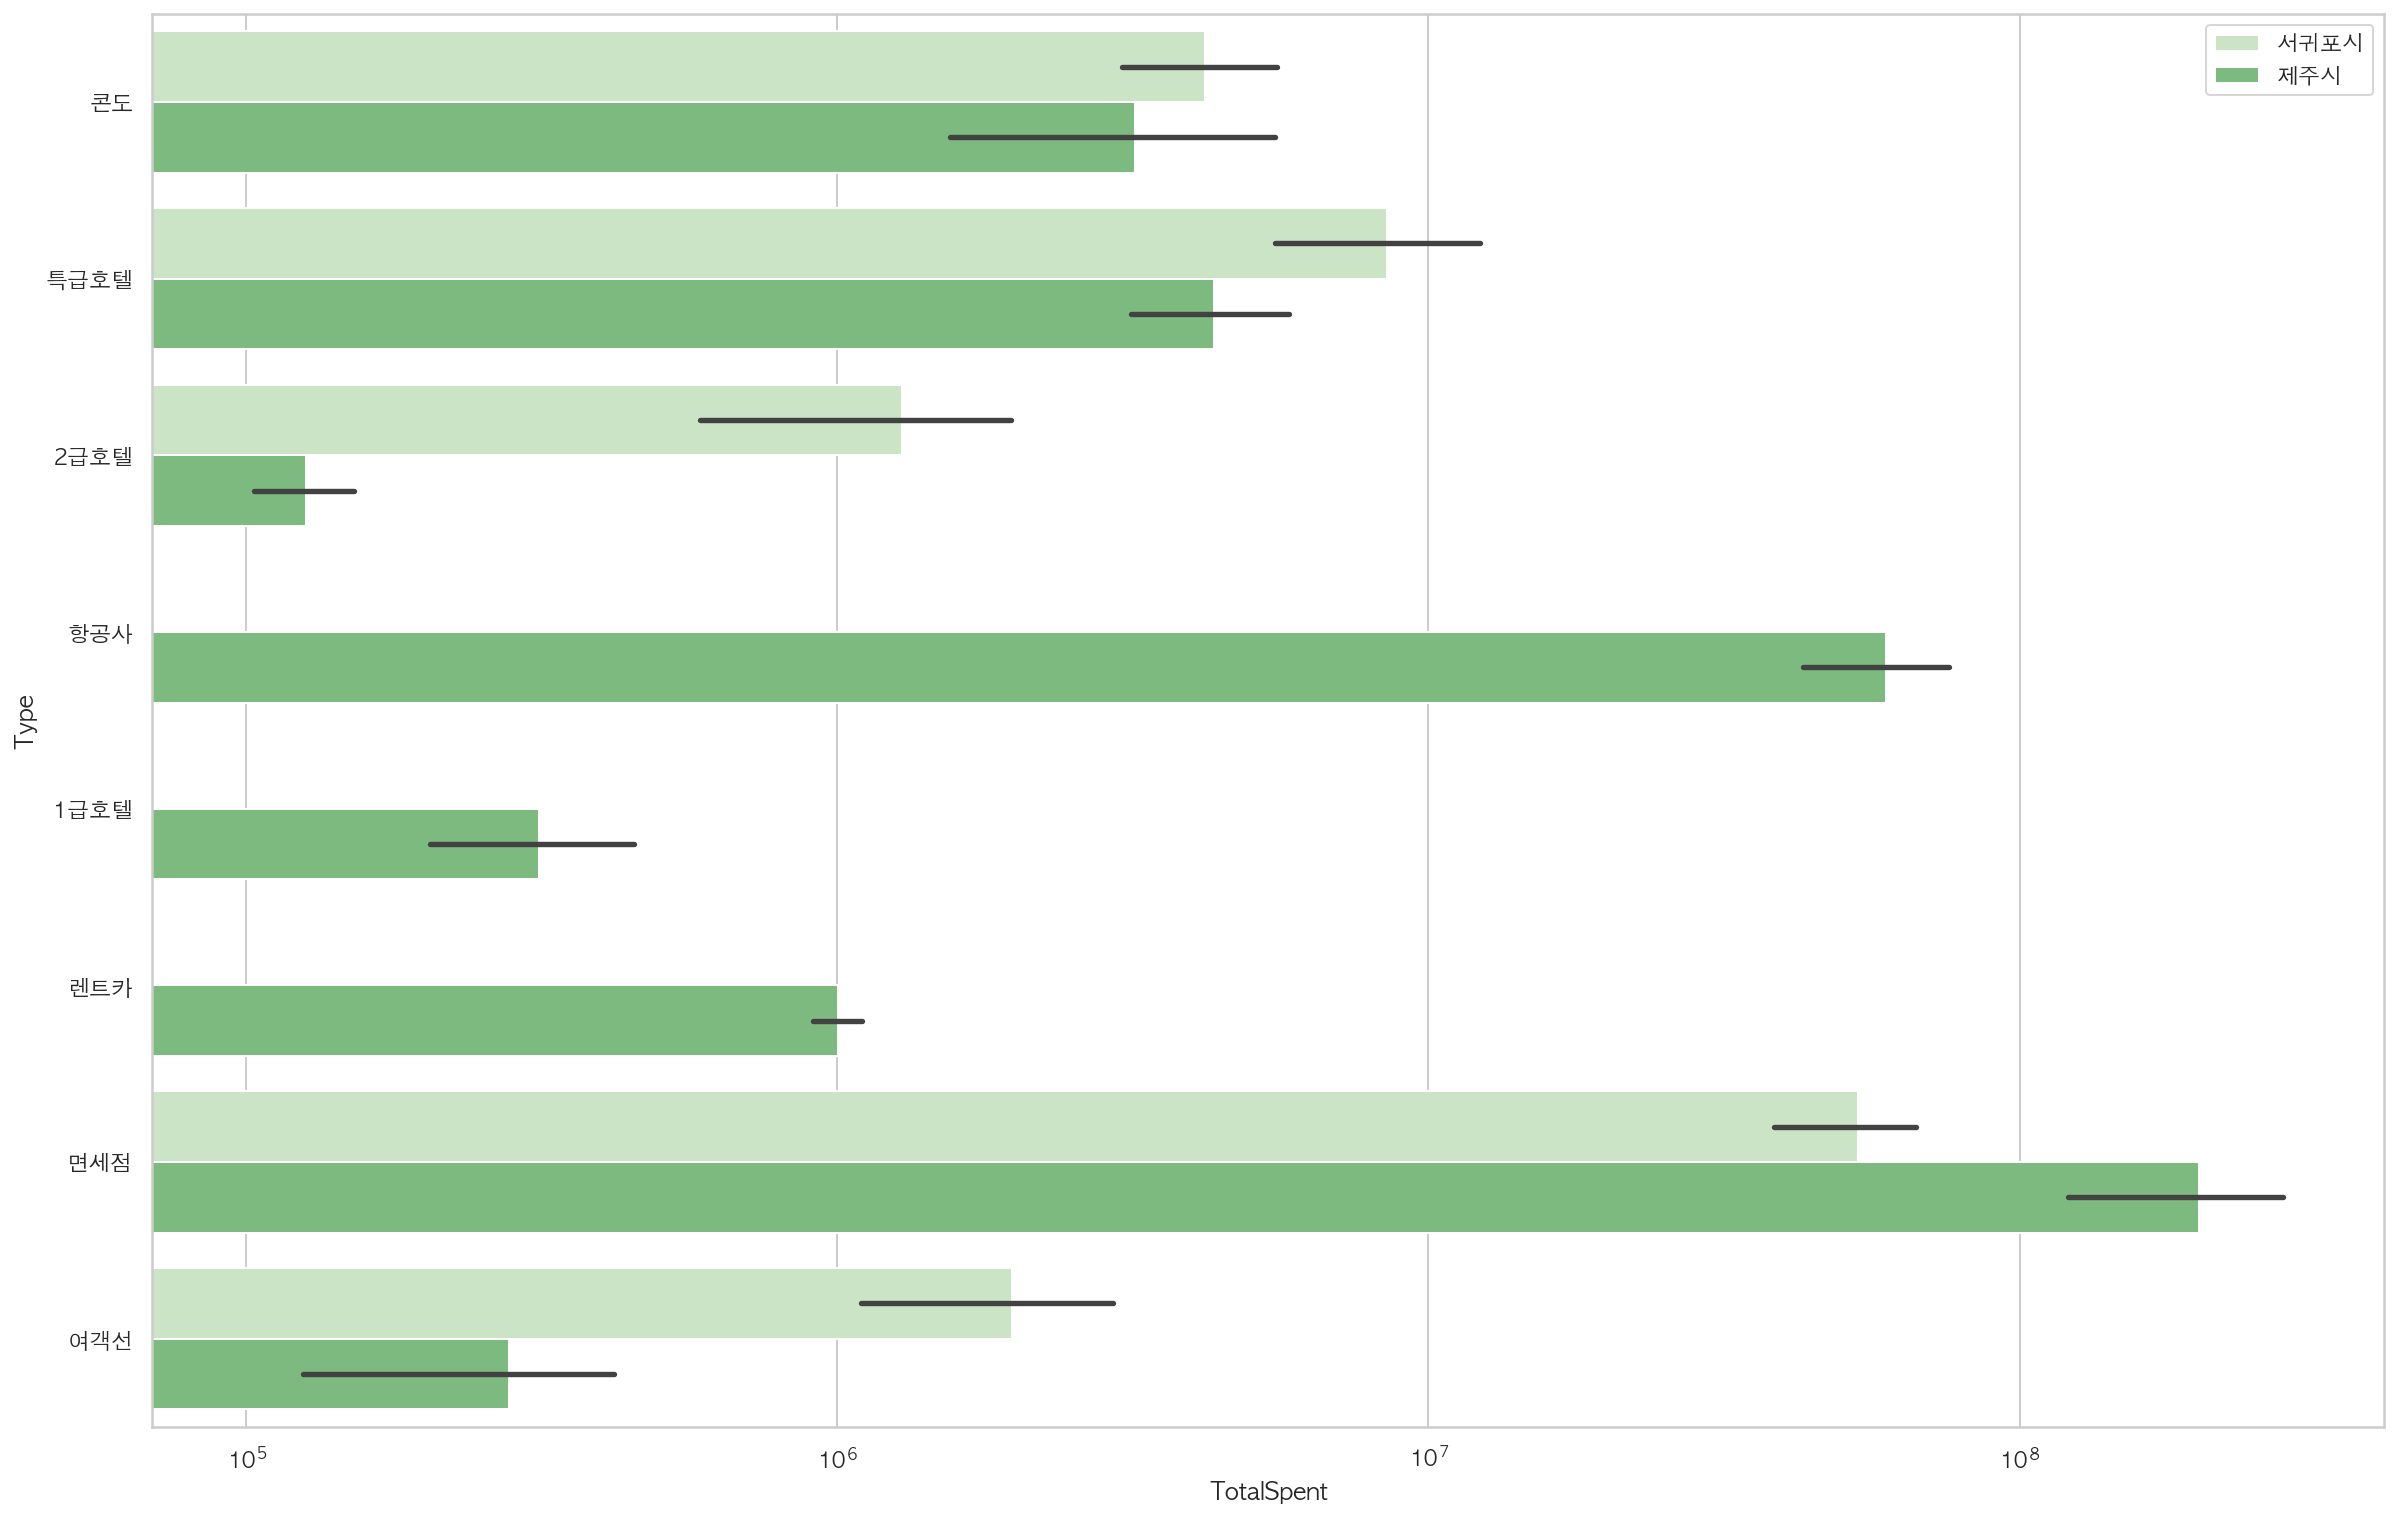

In [8]:
sigungu_1 = data_tour.loc[data_tour.Sigungu.isin(['서귀포시'])]
sigungu_2 = data_tour.loc[data_tour.Sigungu.isin(['제주시'])]

sns.set(rc={'axes.unicode_minus':False}, font='AppleGothic', style='whitegrid')
sns.set_palette('Greens', 3)

plt.figure(figsize=(20,13))
sns.barplot(x='TotalSpent', y='Type', hue='Sigungu', data=data_tour, log='y')

plt.legend()
plt.show()

#### 제주시, 서귀포시 관광업종 매출액 비교
- 관광객이 유입되는 공항이 있는 제주시의 총 매출액이 서귀포시보다 월등히 높다.

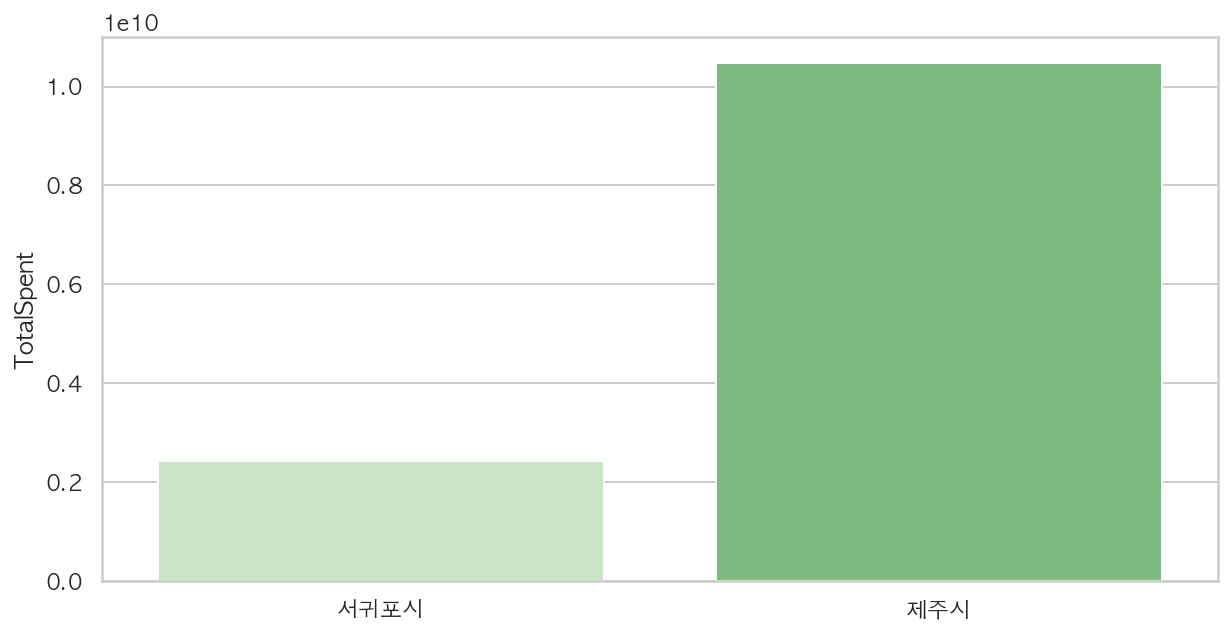

In [9]:
datatour_pivot = data_tour.pivot_table(index='Sigungu', values=['TotalSpent', 'Type'], aggfunc='sum')

sns.set(rc={'axes.unicode_minus':False}, font='AppleGothic', style='whitegrid')
sns.set_palette('Greens', 3)

plt.figure(figsize=(10,5))
sns.barplot(x=datatour_pivot.index.tolist(), y='TotalSpent', data=datatour_pivot)

plt.show()

In [10]:
datatour_pivot.astype(str)
datatour_pivot['TotalSpent']= datatour_pivot['TotalSpent'].astype(int)
datatour_pivot

TotalSpent
Sigungu             
서귀포시      2411916254
제주시      10479169763

<U>제주 내 '소비력'있는 소비자를 타겟으로 하기 위해 '제주시'를 중심으로 관광업종의 소비가 많은 지역을 찾아본다.</U>

In [11]:
jejusi = pd.read_csv('../datas/guest_consumptionType_jejusi.csv', sep=',', encoding='utf-8')
jejusi['Dong'].dropna()
jejusi = jejusi.iloc[:, 2:]
jejusi = jejusi.reindex()

# x시 제거
drop_target = jejusi[jejusi['Time']=='x시'].index.tolist()
jejusi = jejusi.drop(index=drop_target)
jejusi.tail(3)

YM     Sido Sigungu FranClass   Type Time  TotalSpent  DisSpent  \
6276  202005  제주특별자치도     제주시        영세  기타숙박업  23시      280000         0   
6277  202005  제주특별자치도     제주시        영세  기타숙박업  23시        6000         0   
6278  202005  제주특별자치도     제주시       중소2  기타숙박업  23시      234000         0   

      NumofSpent  NumofDisSpent      POINT_X      POINT_Y LargeCategory  \
6276           1              0  940815.8569  1503361.925           숙박업   
6277           1              0  940964.1145  1503712.502           숙박업   
6278           1              0  942360.9005  1504269.001           숙박업   

     MediumCategory      Proj_X     Proj_Y Dong  
6276            여관업  126.860550  33.523305  구좌읍  
6277            여관업  126.862124  33.526475  구좌읍  
6278            여관업  126.877129  33.531570  구좌읍

#### 제주시 관광업종 읍,면,동 시간대별 소비횟수 변화
- '한림읍', '애월읍' 주변에서 꾸준한 소비가 이루어짐을 알 수 있다.
- '조천읍', '구좌읍' 주변에서 오후 시간대 소비가 활발히 이루어짐을 알 수 있다.

<Figure size 2160x5616 with 0 Axes>

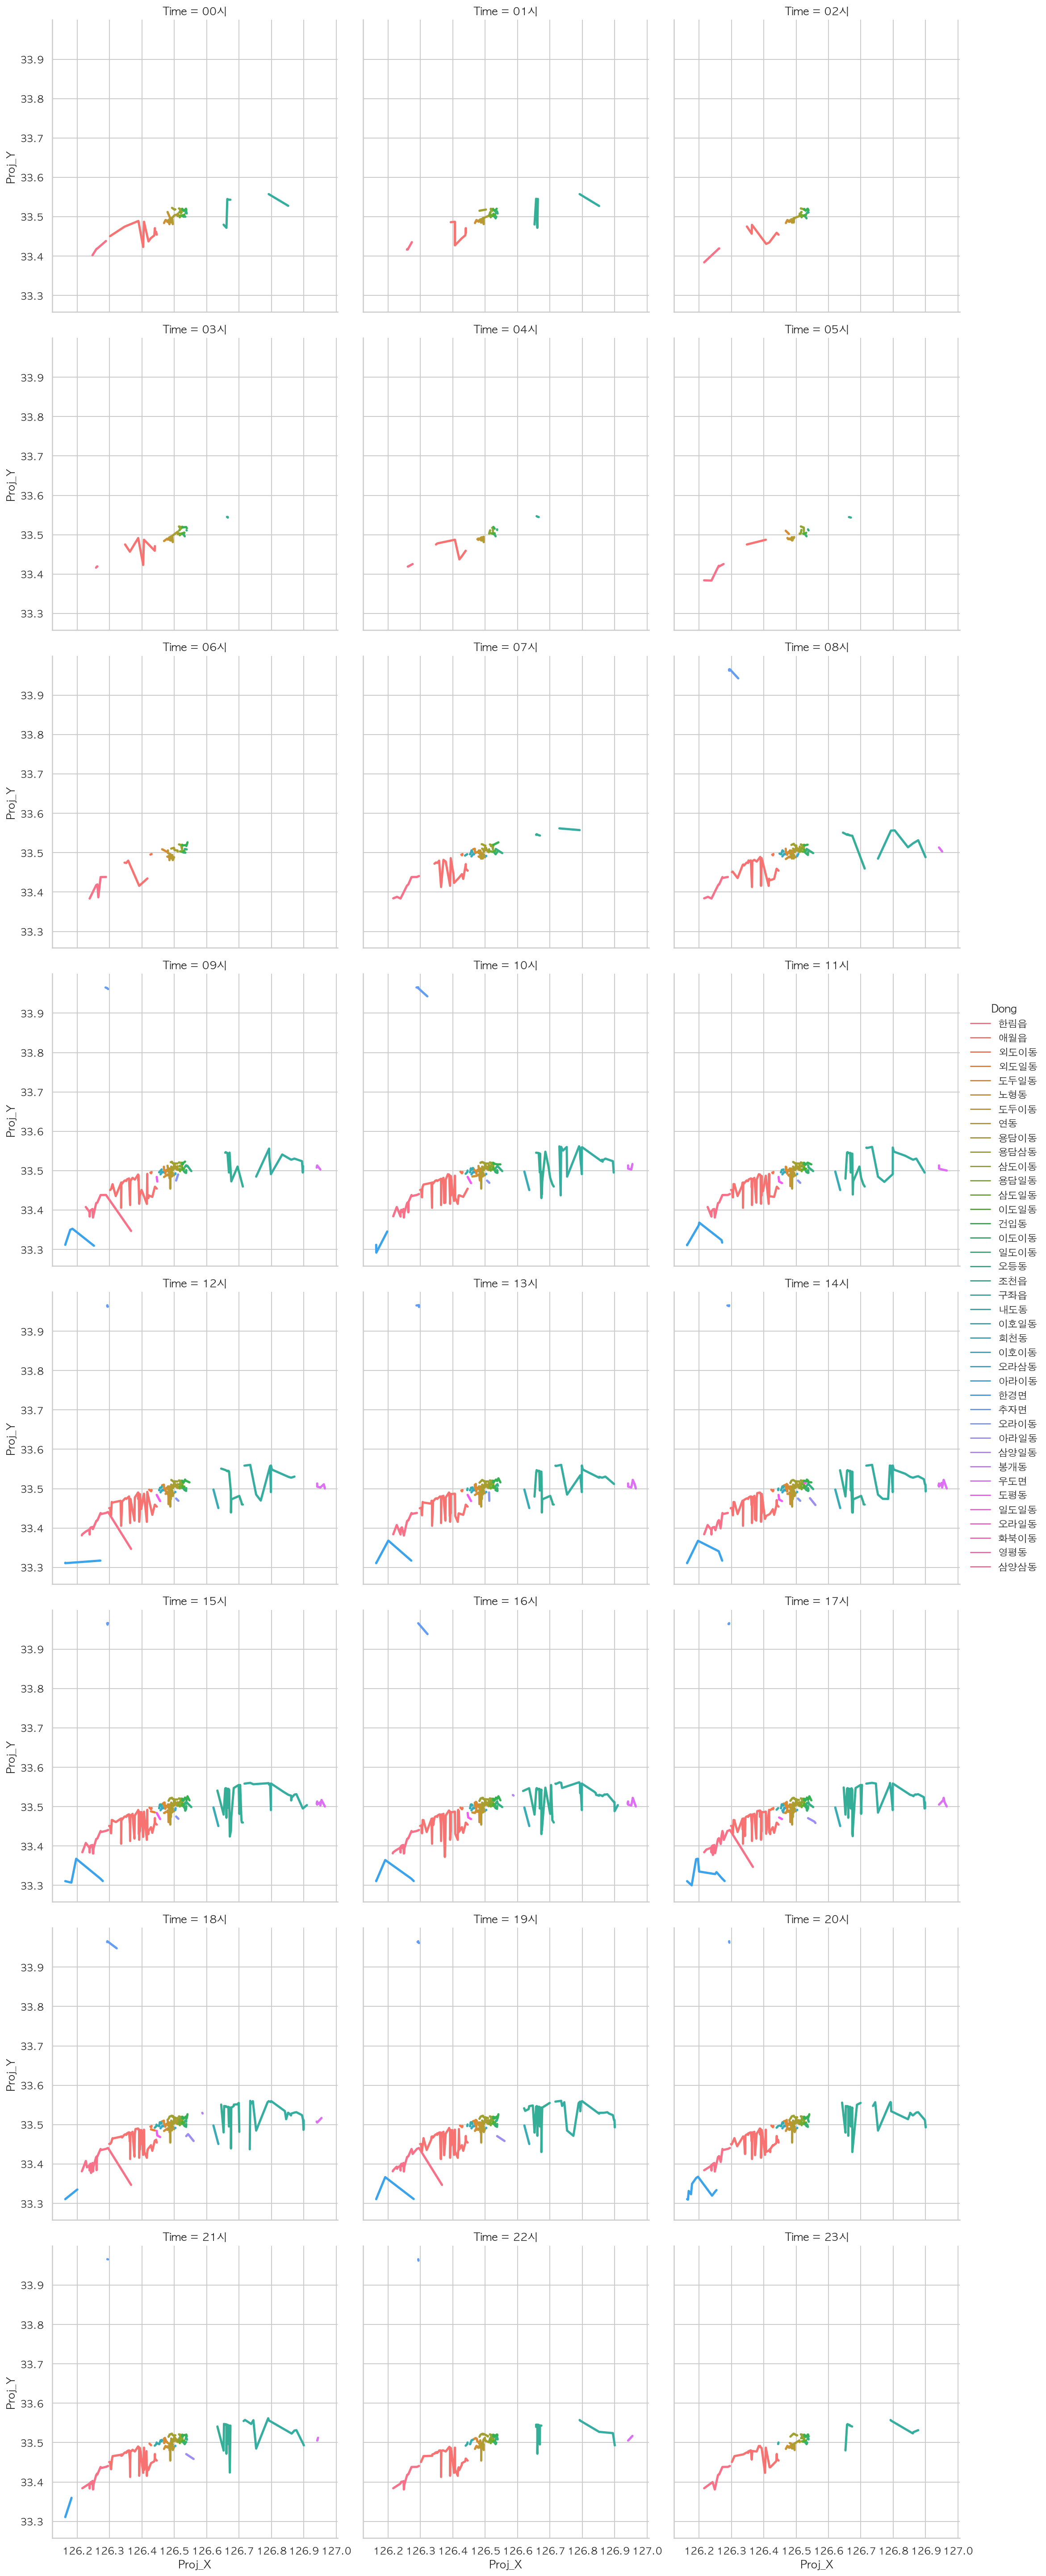

In [12]:
plt.figure(figsize=(30,78))
sns.set(rc={'axes.unicode_minus':False}, font='AppleGothic', style='whitegrid')
sns.set_palette('Greens', 3)

sns.relplot(x='Proj_X', y='Proj_Y', hue='Dong', col='Time', kind='line',
            col_wrap=3, height=5, linewidth=2.5, data=jejusi)

#### 제주시 읍,면,동 관광업종 소비 분석
- 제주시 용담이동에는 공항이 있어 '면세점' 업종과 '항공' 업종의 관광객 소비가 월등히 많다.

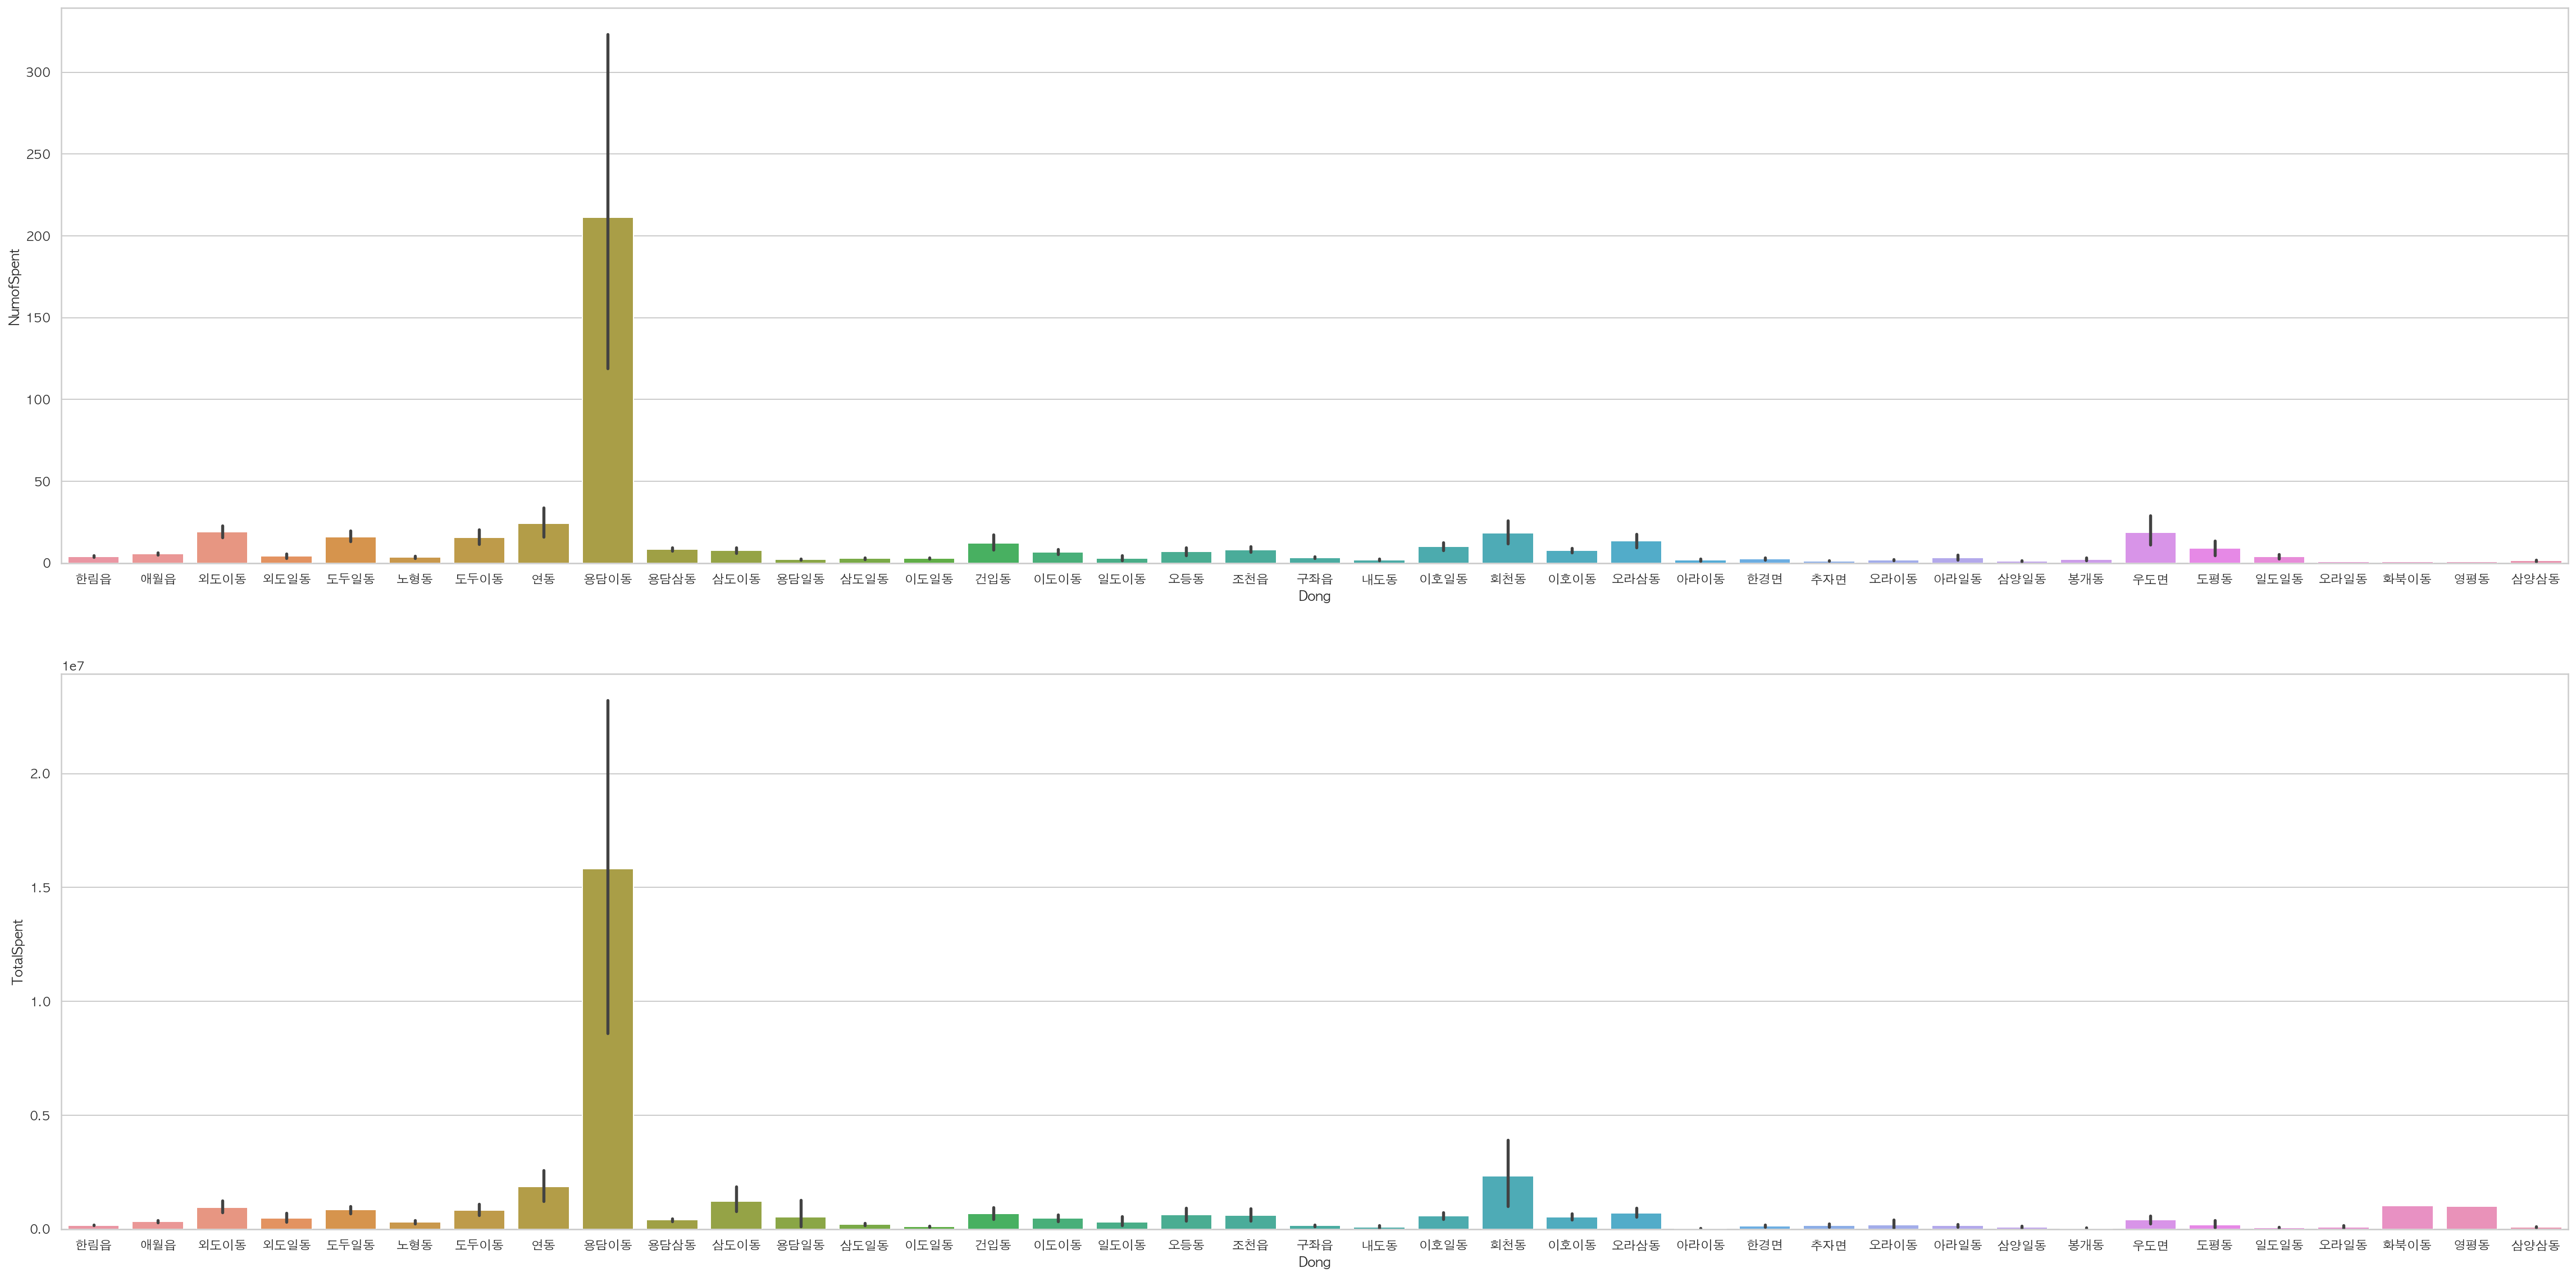

In [13]:
# 제주시 동별 관광객 주업종 NumofSpent, TotalSpent
sns.set(rc={'axes.unicode_minus':False}, font='AppleGothic', style='whitegrid')
fig, axes = plt.subplots(2,1, figsize=(40,20))
sns.set_palette('Greens', 3)

sns.barplot(ax=axes[0], x='Dong', y='NumofSpent', data=jejusi)
sns.barplot(ax=axes[1], x='Dong', y='TotalSpent', data=jejusi)
plt.show()

#### '용담이동'을 제외한 나머지 제주시 동별 소비
- 공항주변과 관광객이 많은 '외도이동', '연동'을 중심으로 관광업종의 소비가 이루어짐을 알 수 있다.

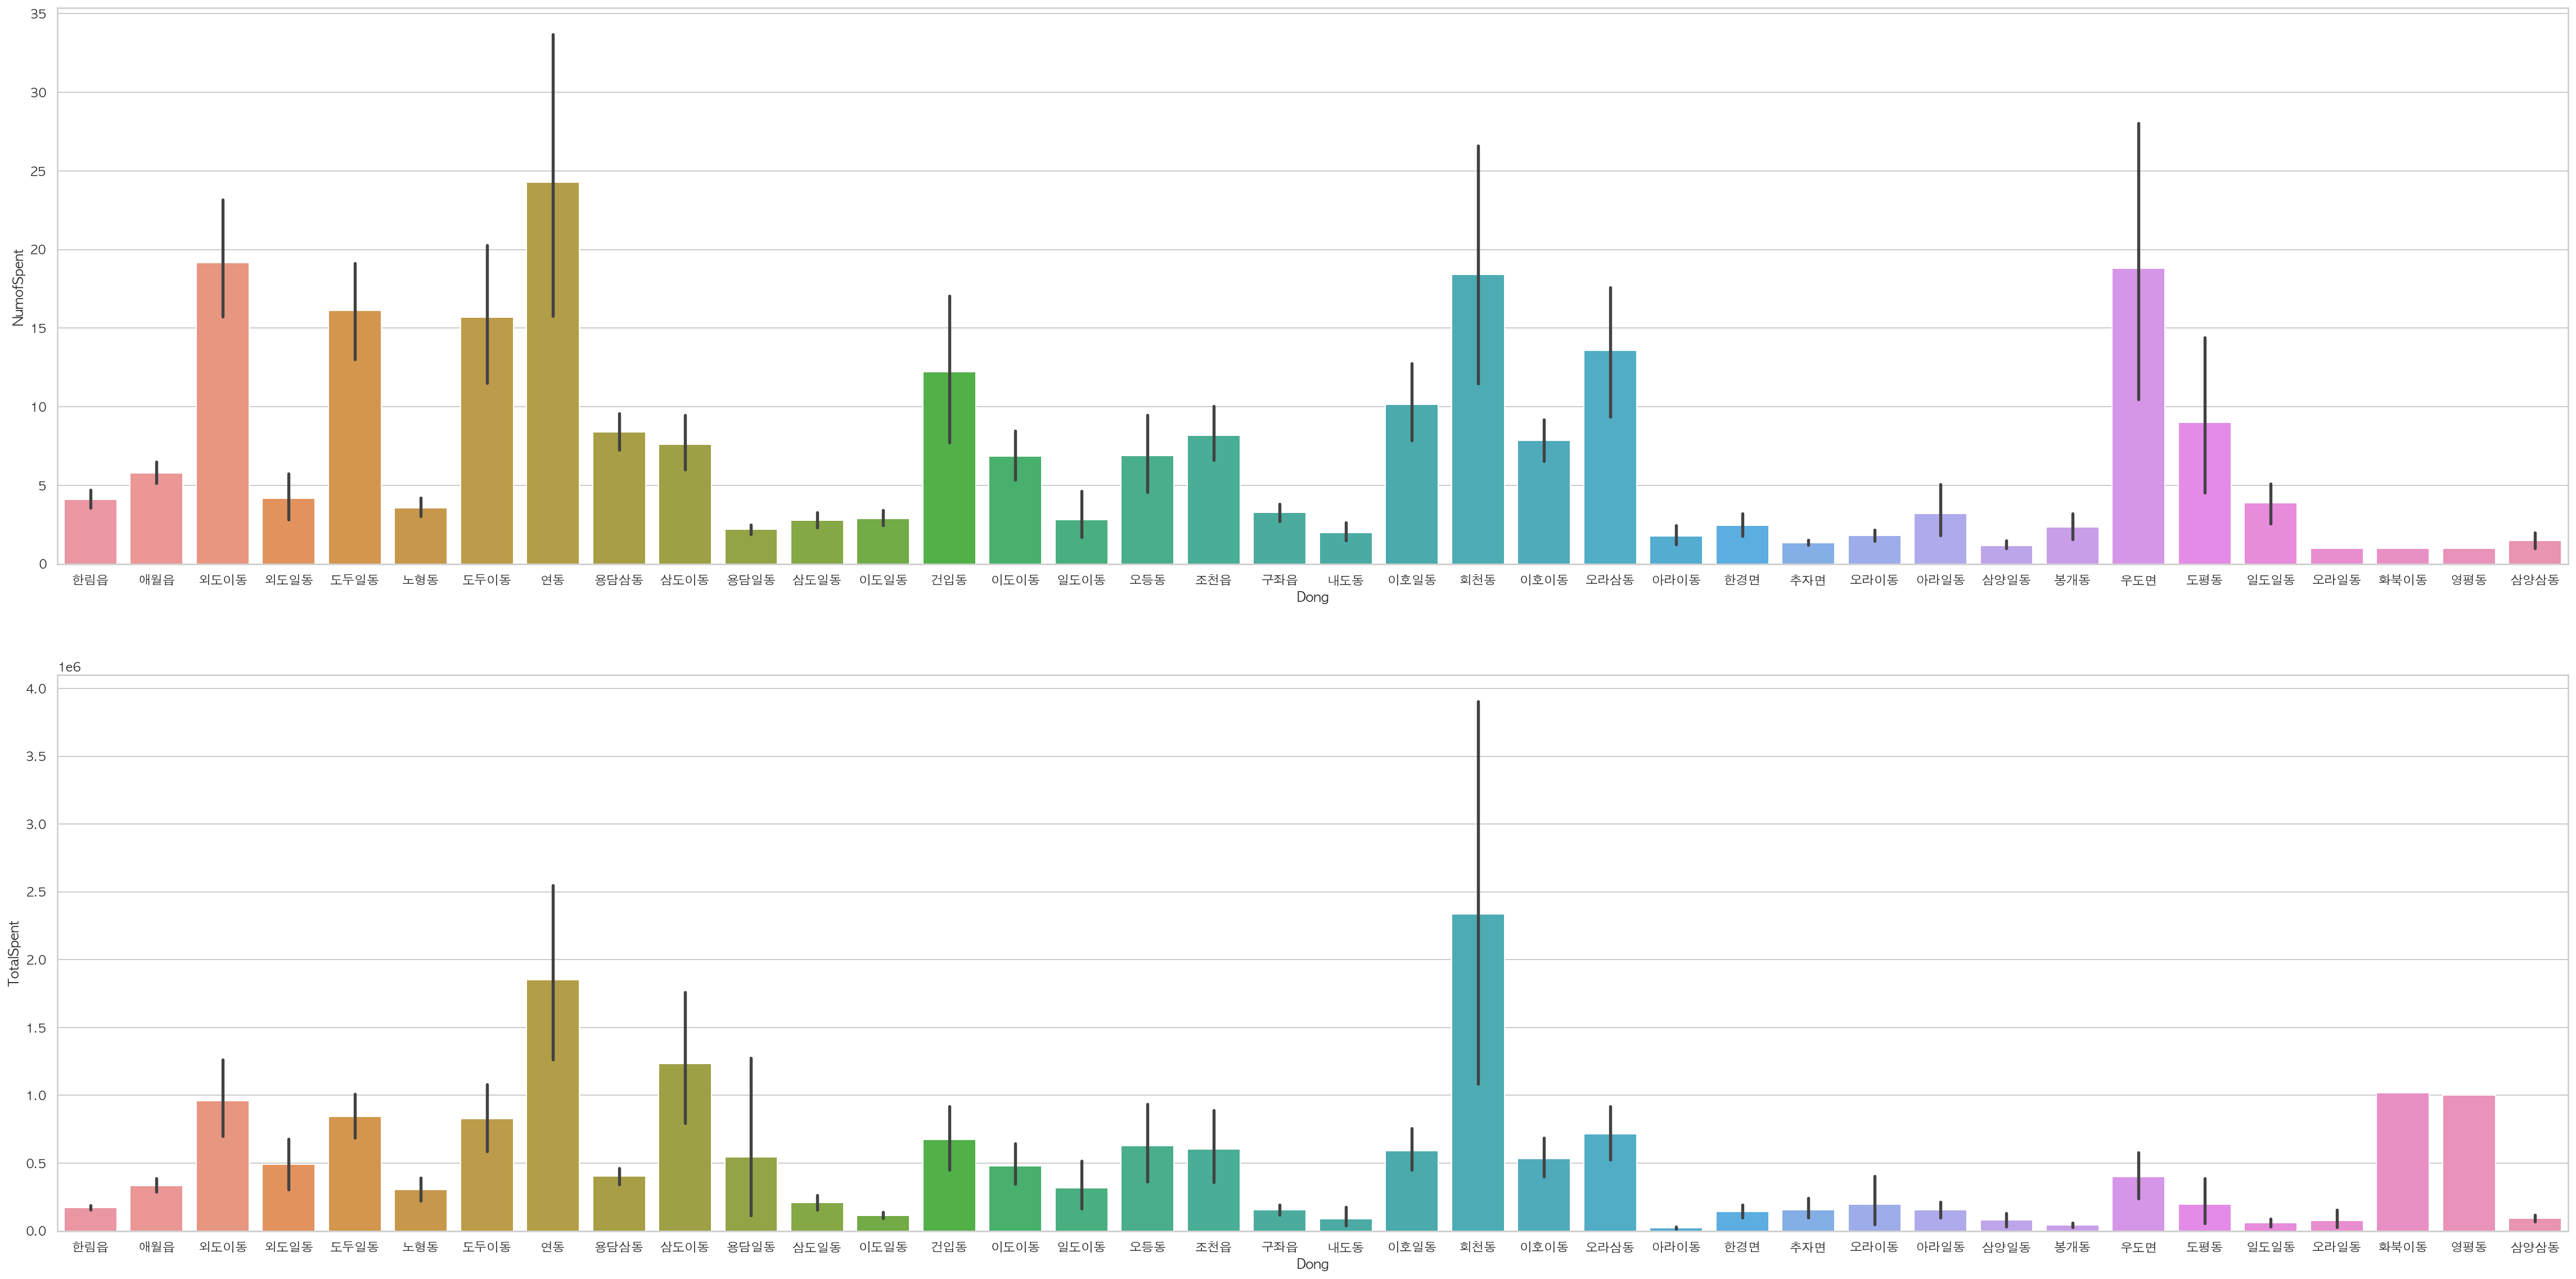

In [13]:
# '용담이동'을 제외한 나머지 제주시 동별 NumofSpent, TotalSpent
yongdam2_index = jejusi.index[jejusi['Dong'] == '용담이동'].tolist()
drop_yongdam2_df = pd.DataFrame(columns=jejusi.columns, data=jejusi.drop(index=yongdam2_index))

sns.set(rc={'axes.unicode_minus':False}, font='AppleGothic', style='whitegrid')
fig, axes = plt.subplots(2,1, figsize=(40,20))

sns.barplot(ax=axes[0], x='Dong', y='NumofSpent', data=drop_yongdam2_df)
sns.barplot(ax=axes[1], x='Dong', y='TotalSpent', data=drop_yongdam2_df)
plt.show()

#### 제주시 읍,면,동별 관광업종 folium
- 읍,면,동별 소비 횟수 기준
- 읍,면,동별 총 매출액 기준

In [24]:
# 제주시 행정구역 .shp 파일 geopandas로 불러오기
emd = gpd.read_file("../datas/EMD_202101/TL_SCCO_EMD.shp", encoding='euc-kr')
jeju_emd = emd.loc[(emd['EMD_CD'].str.startswith('5011')|emd['EMD_CD'].str.startswith('5013'))]
jeju_emd['geometry'] = jeju_emd['geometry'].to_crs('EPSG:4326')


# 제주시 관광업종 소비 데이터 기준으로 읍,면,동 정리
jejusi['Dong'].dropna()
df_jeju_dong = pd.DataFrame(jejusi.groupby(['Dong'])['NumofSpent'].count())
jeju_guest_dong = df_jeju_dong.index.tolist() 

indexlist = emd.index.tolist()
targets = []

for i in range(len(jeju_guest_dong)):
    if jeju_guest_dong[i] in jeju_emd['EMD_KOR_NM'].tolist():
        target_index = jeju_emd[jeju_emd['EMD_KOR_NM'] == jeju_guest_dong[i]].index.tolist()
        targets.append(target_index[0])
        
emd = emd.loc[targets]


# 제주시 11개 관광업종 소비횟수
f = folium.Figure(width=600, height=400)
m = folium.Map(location = [33.363, 126.533], zoom_start= 10)
m.add_to(f)

folium.Choropleth(
            geo_data=emd, 
            data = df_jeju_dong['NumofSpent'],
            key_on = 'feature.properties.EMD_KOR_NM',
            columns = (df_jeju_dong.index,df_jeju_dong['NumofSpent']),
            fill_color = 'YlGn',
            fill_opacity=0.5,
            line_opacity=0.5,
            overlays = True,
            highlight=True
         ).add_to(m)

m

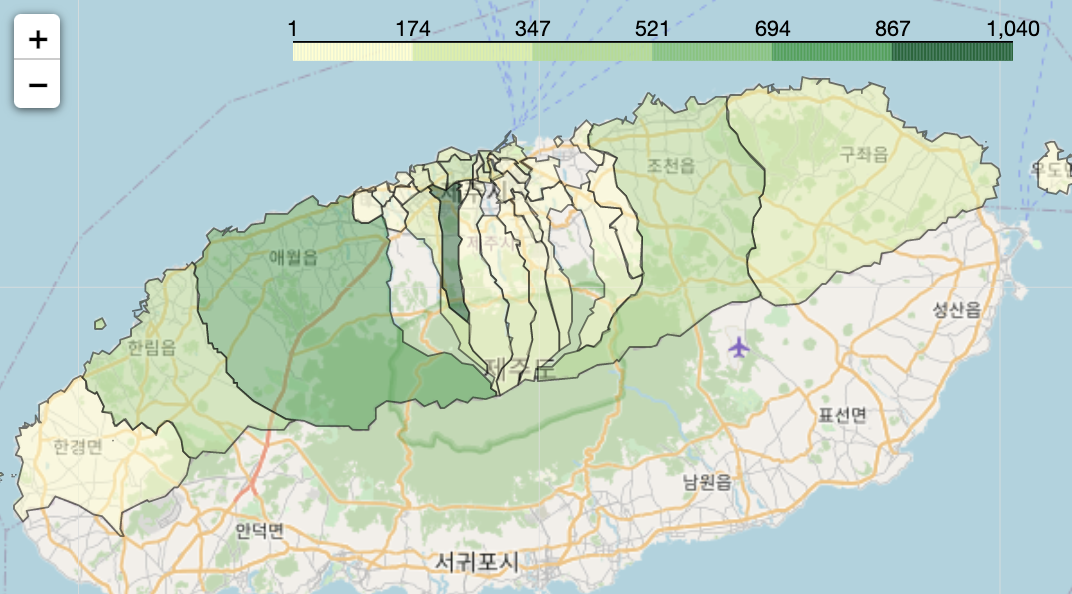

In [33]:
Image('../datas/folium_numofspent.png')

In [25]:
# 제주시 8개 관광업종 총 매출액
f = folium.Figure(width=600, height=400)
m = folium.Map(location = [33.363, 126.533], zoom_start= 10)
m.add_to(f)

df_jeju_dong = pd.DataFrame(jejusi.groupby(['Dong'])['TotalSpent'].count())
jeju_guest_dong = df_jeju_dong.index.tolist() 

folium.Choropleth(
            geo_data=emd, 
            data = df_jeju_dong['TotalSpent'],
            key_on = 'feature.properties.EMD_KOR_NM',
            columns = (df_jeju_dong.index,df_jeju_dong['TotalSpent']),
            fill_color = 'YlGn',
            fill_opacity=0.5,
            line_opacity=0.5,
            overlays = True,
            highlight=True
         ).add_to(m)

m

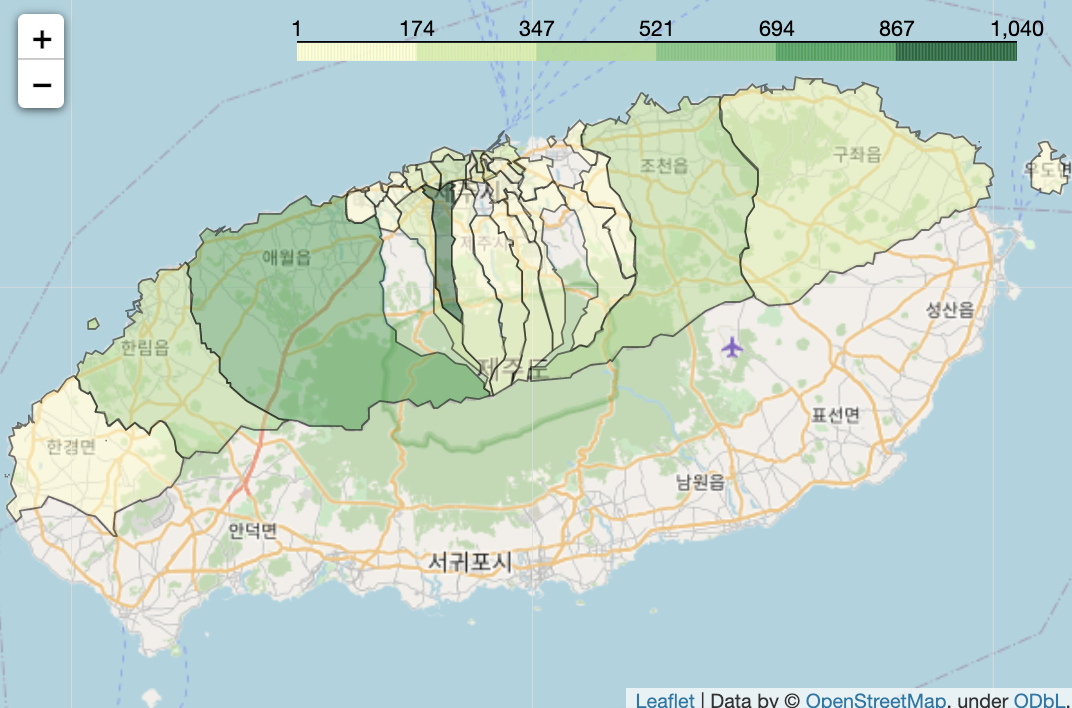

In [34]:
Image('../datas/folium_totalspent.png')

----
<strong>위도, 경도를 주소로 변환</strong>
- reverse geocoding을 이용해 위도, 경도를 실제 주소로 변환한다.

In [398]:
# api key 호출
def get_secretKeys():
    
    file = open("../keys/secret_keys.txt", "rt")
    split_keys = []
    line_count = 0
    
    load_datas = file.readlines()
    
    file.close()
    
    for i in range(len(load_datas)):
        split_keys.append(load_datas[i].split('=')[1].replace('"', ""))
    
    return split_keys


# api 요청 url 생성
def get_search_url(req_x, req_y):
    
    api_list = get_secretKeys()
    
    base = "https://dapi.kakao.com/v2/local/geo/coord2regioncode.json"     
    header_phrase = "KakaoAK"
    api_key = api_list[1] 
    
    
    headers = {"Authorization": header_phrase + api_key[1:]} # api_key[1:] = 공백 제거
    
    req_lat = "?x=" + str(req_x)
    req_lng = "&y=" + str(req_y)
    
    url = base + req_lat + req_lng
    req_set = (url, headers)
    
    return req_set

def get_result(url, header):
    
    req = requests.get(url, headers=header)
    res = json.loads(req.text)
     
    return res


# 변환된 위도,경도를 주소로 요청
def reverse_geocoding(req_x, req_y):

    req_set = get_search_url(req_x, req_y)
    res_api = get_result(req_set[0], req_set[1])
    
    return res_api


# reverse geocoding start
proj_x = [jejusi['Proj_X'].tolist()]
proj_y = [jejusi['Proj_Y'].tolist()]

res_json = []

for i in range(len(proj_x[0])):
    try:
        raw_res_json = reverse_geocoding(proj_x[0][i], proj_y[0][i])
        res_json.append(raw_res_json['documents'][0]['region_3depth_name'])
    except:
        res_json.append('')

        
jejusi['Dong'] = res_json
jejusi.to_csv('../datas/guest_consumptionType_jejusi.csv', encoding='utf-8-sig')

6317

----
<strong>제주시 11개 관광업종 좌표 변환</strong>
- 기존 ITRF2000 좌표계를 표준 위도, 경도로 변환한다.

In [31]:
sigungu_2.reset_index(inplace=True, drop=True)

# 좌표 변환
def change_lat_lng(path_x, path_y):
    
    itrf_x, itrf_y = path_x, path_y
    
    proj_UTMK = Proj(init='epsg:5178') #기존 좌표계: ITRF2000
    proj_WGS84 = Proj(init='epsg:4326') #변환할 좌표계
    
    x, y = transform(proj_UTMK, proj_WGS84, itrf_x, itrf_y)
    latlng = (x, y)
    
    return latlng

raw_xy = sigungu_2[['POINT_X', 'POINT_Y']]
raw_xy

# ITRF2000 좌표계 좌표
def get_transform_xy(raw_xy):
    
    transform_xy = []
    latlng_df = raw_xy
    
    for i in range(len(latlng_df)):
        raw_x = latlng_df['POINT_X'].iloc[i]
        raw_y = latlng_df['POINT_Y'].iloc[i]

        res = change_lat_lng(raw_x, raw_y)
        transform_xy.append(res)

    return transform_xy


raw_xy = sigungu_2[['POINT_X', 'POINT_Y']]
res_latlng = get_transform_xy(raw_xy)

get_x, get_y = [], []

for i in range(len(res_latlng)):
    x = str(res_latlng[i][0])
    y = str(res_latlng[i][1])
    
    get_x.append(x)
    get_y.append(y)
    

sigungu_2['Proj_X'] = get_x
sigungu_2['Proj_Y'] = get_y

sigungu_2.to_csv("../datas/guest_consumptionType_jejusi.csv", encoding='utf-8-sig')

NameError: name 'hotel_spent' is not defined